In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from model.resnet import resnet18, ResNet18_Weights
from data.ImageNetV2.superclassing_dataset import SuperclassImageNetV2Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

SUPERCLASS_DATASET_PATH="./data/ImageNetV2/raw/"
SUPER_CLASS_INDEX_PATH = "./data/ImageNetV2/superclass/superclass_index.json"

In [5]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    """
    Plots a confusion matrix with enhancements for clarity.

    Args:
    - y_true: List or array of true labels.
    - y_pred: List or array of predicted labels.
    - class_names: List of class names corresponding to the labels.
    - normalize: Whether to normalize the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f' if normalize else 'd')

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.grid(False)
    plt.show()

In [3]:
train_ratio = 0.8
val_ratio = 0.2

super_dataset = SuperclassImageNetV2Dataset(transform=transform, root=SUPERCLASS_DATASET_PATH, superclass_index_path=SUPER_CLASS_INDEX_PATH)

train_size = int(train_ratio * len(super_dataset))
val_size = len(super_dataset) - train_size

train_dataset, val_dataset = random_split(super_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

superclass_network = resnet18(weights=ResNet18_Weights.DEFAULT)
superclass_network.fc = nn.Linear(superclass_network.fc.in_features, 9)
superclass_network.load_state_dict(torch.load("./results/superclass_network.pth"))
superclass_network.eval()

/var/folders/ft/b0jnqh711l9_cg3jhjr4j_b00000gn/T/ipykernel_24730/3709057742.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  superclass_network.load_state_dict(torch.loa

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

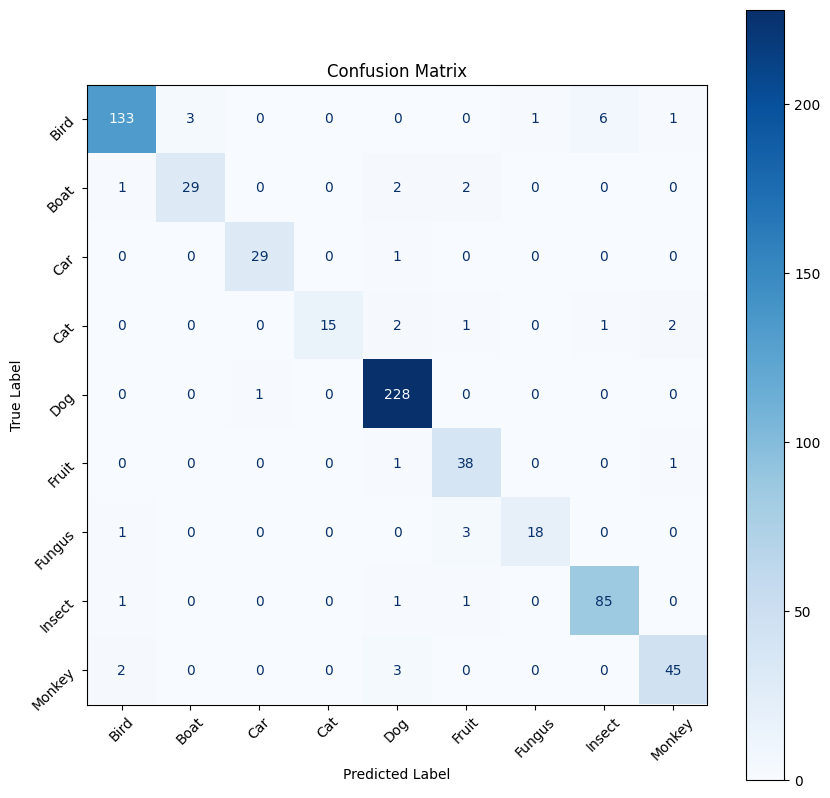

In [6]:
y_true = []
y_pred = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
superclass_network.to(device)

with torch.no_grad():
    for inputs, _, super_labels in val_loader:
        inputs = inputs.to(device)
        super_labels = super_labels.to(device)

        outputs = superclass_network(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(super_labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Plot the confusion matrix
class_names = ["Bird", "Boat", "Car", "Cat", "Dog", "Fruit", "Fungus", "Insect", "Monkey"]
plot_confusion_matrix(y_true, y_pred, class_names)